In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [2]:
import deepxde as dde 
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt

2023-10-07 15:21:35.211335: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-07 15:21:35.211394: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-07 15:21:35.211430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-07 15:21:35.221232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



In [3]:
rho = 1 
mu = 1 
u_in = 1
D = 1 
L = 2

In [4]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

Text(0, 0.5, 'y')

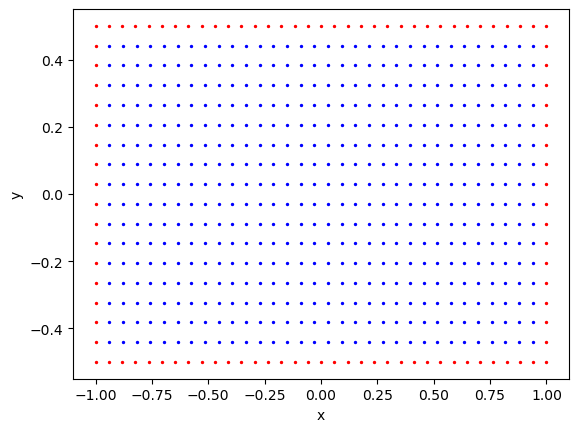

In [5]:
X = geom.uniform_points(500, boundary=False)
X_boundary = geom.uniform_boundary_points(100)
plt.scatter(X[:, 0], X[:, 1], s=2, c='b')
plt.scatter(X_boundary[:, 0], X_boundary[:, 1], s=2, c='r')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

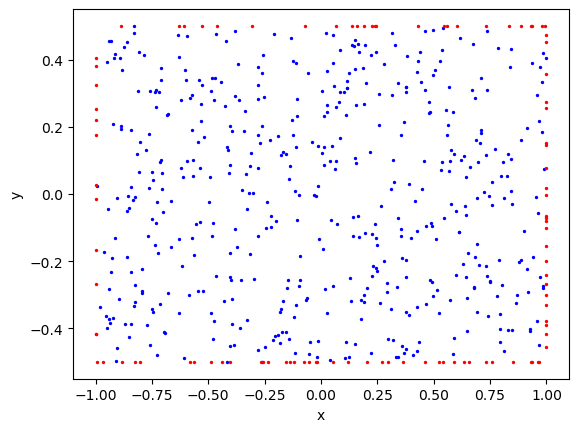

In [6]:
X = geom.random_points(500)
X_boundary = geom.random_boundary_points(100)
plt.scatter(X[:, 0], X[:, 1], s=2, c='b')
plt.scatter(X_boundary[:, 0], X_boundary[:, 1], s=2, c='r')
plt.xlabel('x')
plt.ylabel('y')

In [7]:
def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
    return on_wall 

def boundary_inlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], L/2)

In [8]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i = 0, j = 0)
    du_y = dde.grad.jacobian(Y, X, i = 0, j = 1)
    
    dv_x = dde.grad.jacobian(Y, X, i = 1, j = 0)
    dv_y = dde.grad.jacobian(Y, X, i = 1, j = 1)

    dp_x = dde.grad.jacobian(Y, X, i = 2, j = 0)
    dp_y = dde.grad.jacobian(Y, X, i = 2, j = 1)

    du_xx = dde.grad.hessian(Y, X, component = 0, i = 0, j = 0)
    du_yy = dde.grad.hessian(Y, X, component = 0, i = 1, j = 1)

    dv_xx = dde.grad.hessian(Y, X, component = 1, i = 0, j = 0)
    dv_yy = dde.grad.hessian(Y, X, component = 1, i = 1, j = 1)

    u = Y[:, 0:1]
    v = Y[:, 1:2]

    pde_u = u*du_x + v*du_y + (1/rho)*dp_x - (mu/rho)*(du_xx + du_yy)
    pde_v = u*dv_x + v*dv_y + (1/rho)*dp_y - (mu/rho)*(dv_xx + dv_yy)
    pde_con = du_x + dv_y

    return [pde_u, pde_v, pde_con]

In [9]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0, boundary_wall, component=0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0, boundary_wall, component=1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component=0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0, boundary_inlet, component=1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0, boundary_outlet, component=2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0, boundary_outlet, component=1)

In [10]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v],
                    num_domain = 3000,
                    num_boundary = 500,
                    num_test = 1000,
                    train_distribution = 'LHS')

In [11]:
data.train_x_all.shape

(3500, 2)

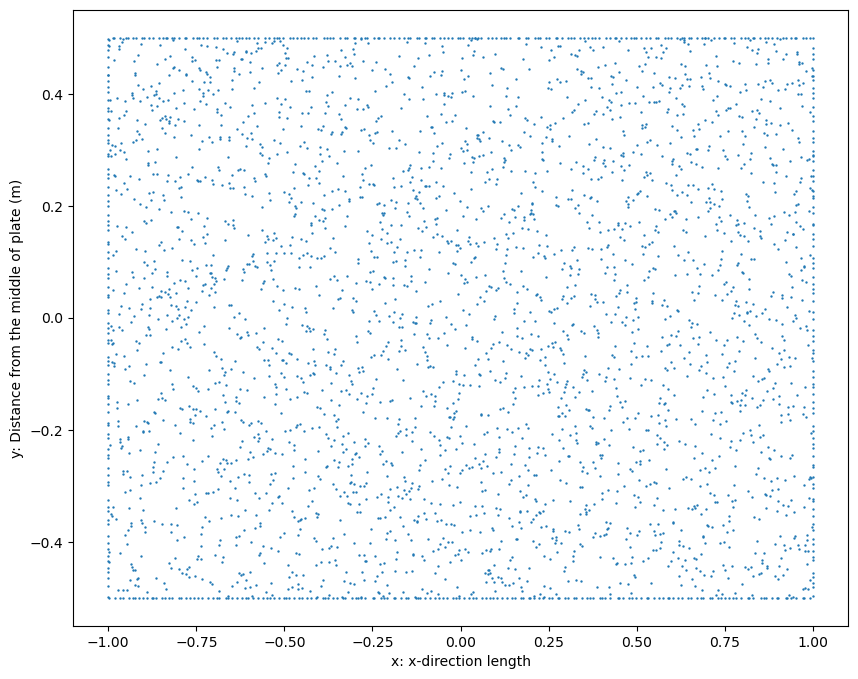

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1], s = 0.5)
plt.xlabel('x: x-direction length')
plt.ylabel('y: Distance from the middle of plate (m)')
plt.show()

In [13]:
layer_size = [2] + [64] * 5 + [3]
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.maps.FNN(layer_size, activation, initializer)

2023-10-07 15:22:37.222238: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-07 15:22:37.223221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:82:00.0, compute capability: 7.0


In [14]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.009737 s



In [15]:
samples = geom.uniform_points(500000)
result = model.predict(samples)
samples.shape, result.shape

/userhome/jeon_mg/miniforge3/envs/pinn_tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2023-10-07 15:22:39.930928: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560a9e1d9890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-07 15:22:39.930974: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2023-10-07 15:22:39.938657: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-07 15:22:40.539097: I tensorflow/compiler

((500000, 2), (500000, 3))

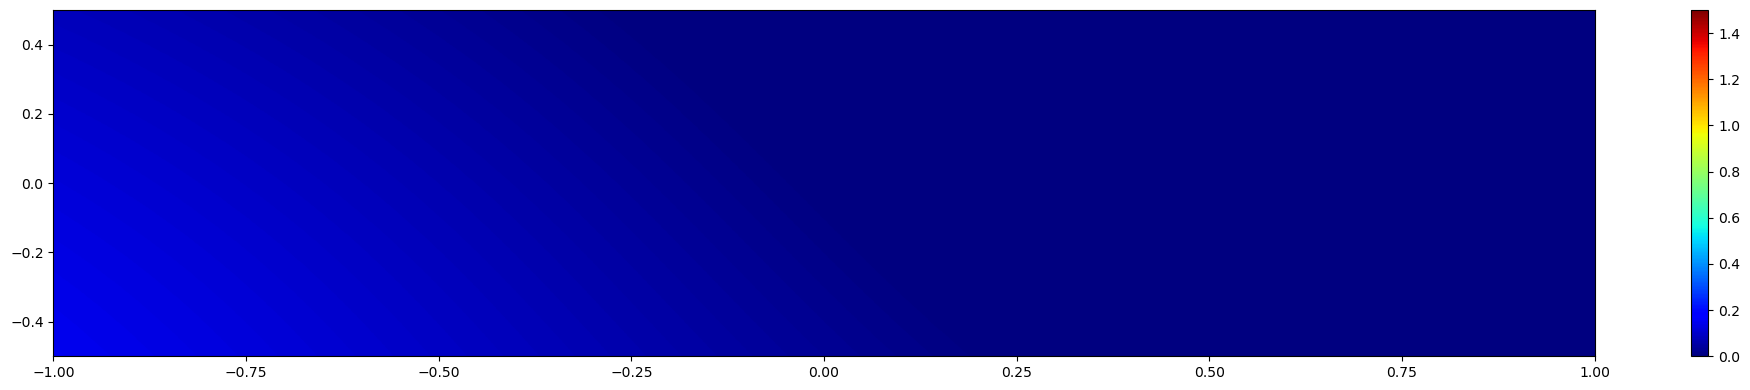

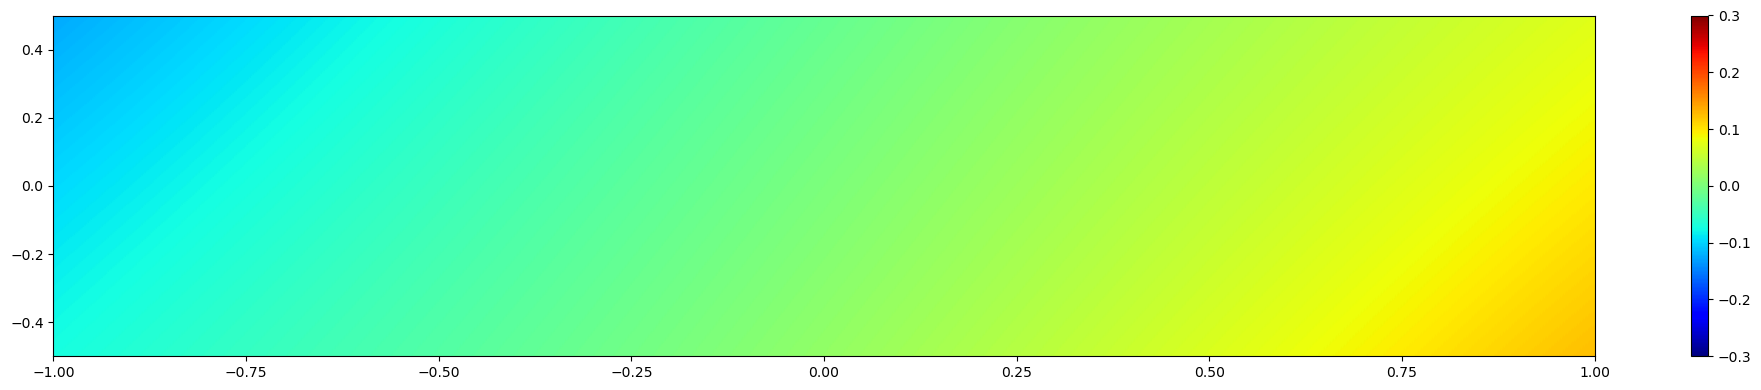

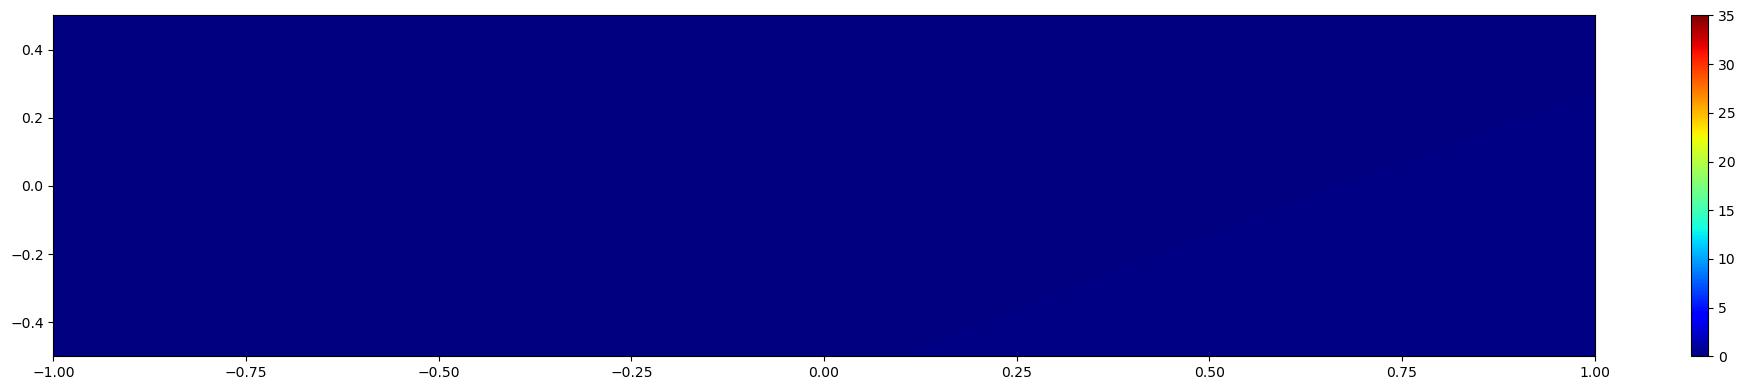

In [16]:
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize=(20, 4))
    plt.scatter(samples[:, 0], samples[:, 1], c = result[:, idx], cmap='jet', s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((-L/2, L/2))
    plt.ylim((-D/2, D/2))
    plt.tight_layout()
    plt.show()

Training model...

Cause: could not parse the source code of <function <lambda> at 0x7f5344a1d510>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f5344a1d510>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f5344a1d870>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f5

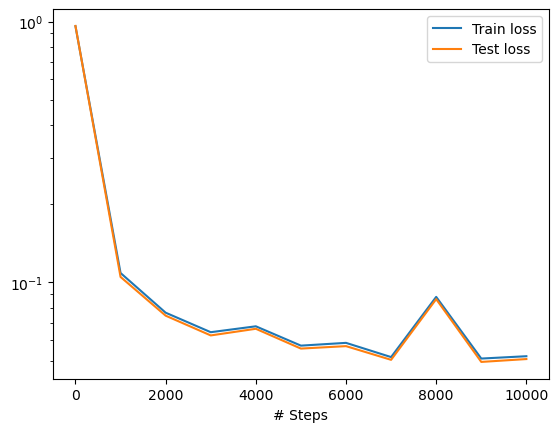

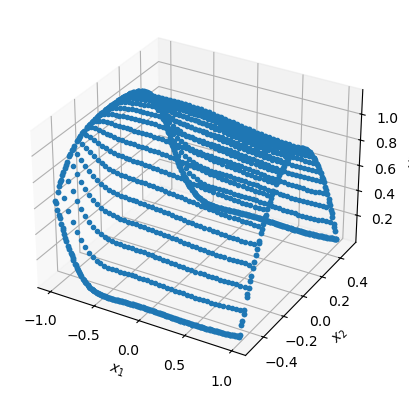

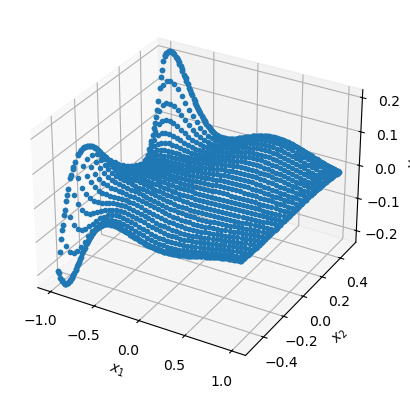

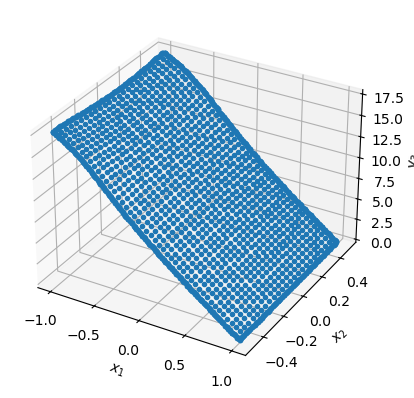

In [17]:
losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

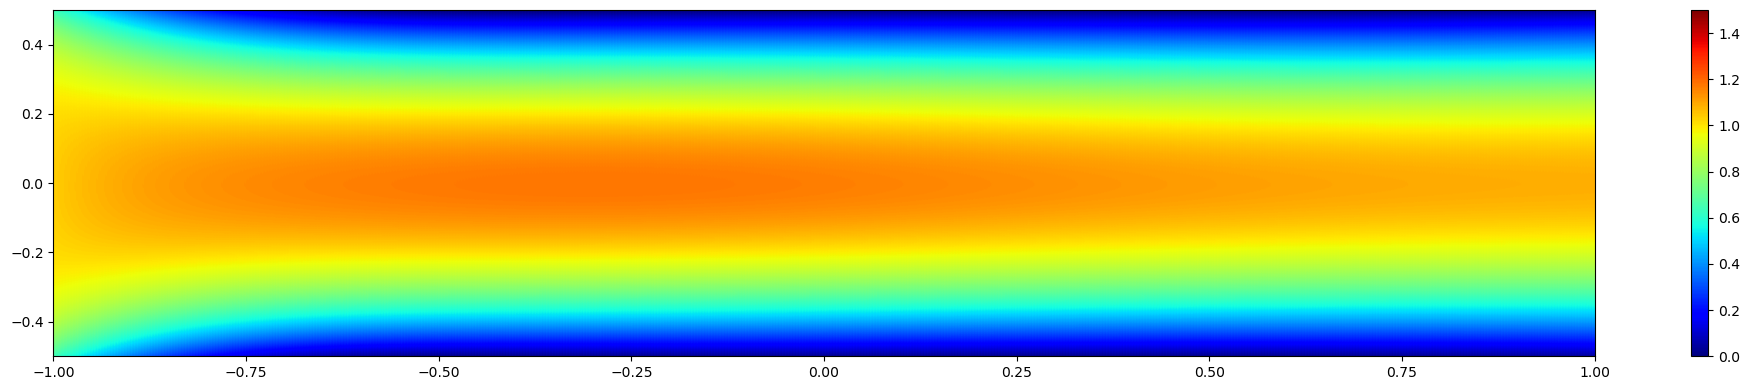

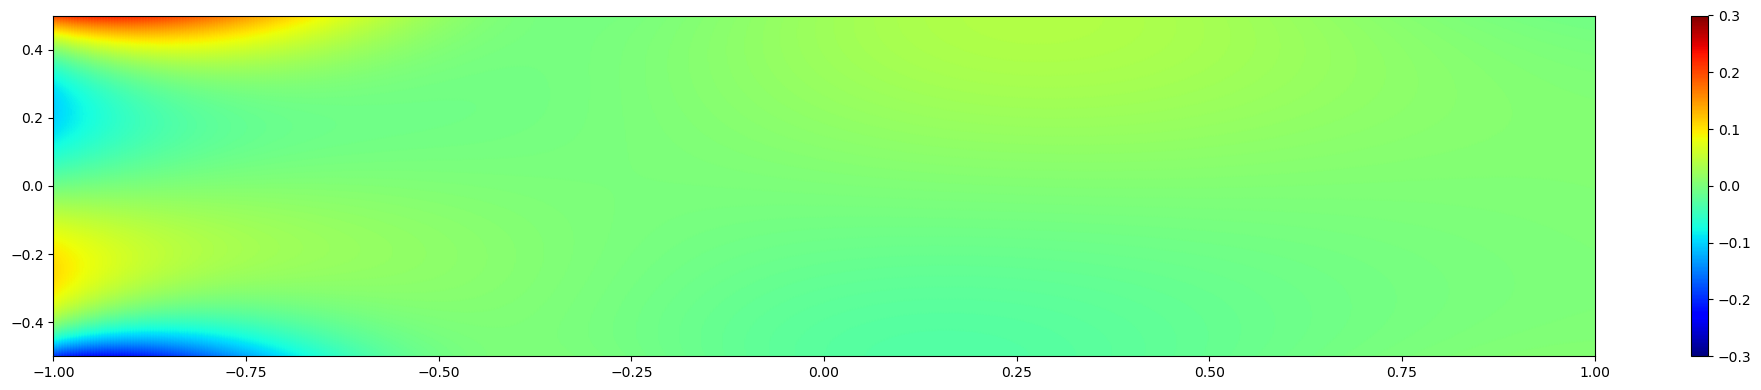

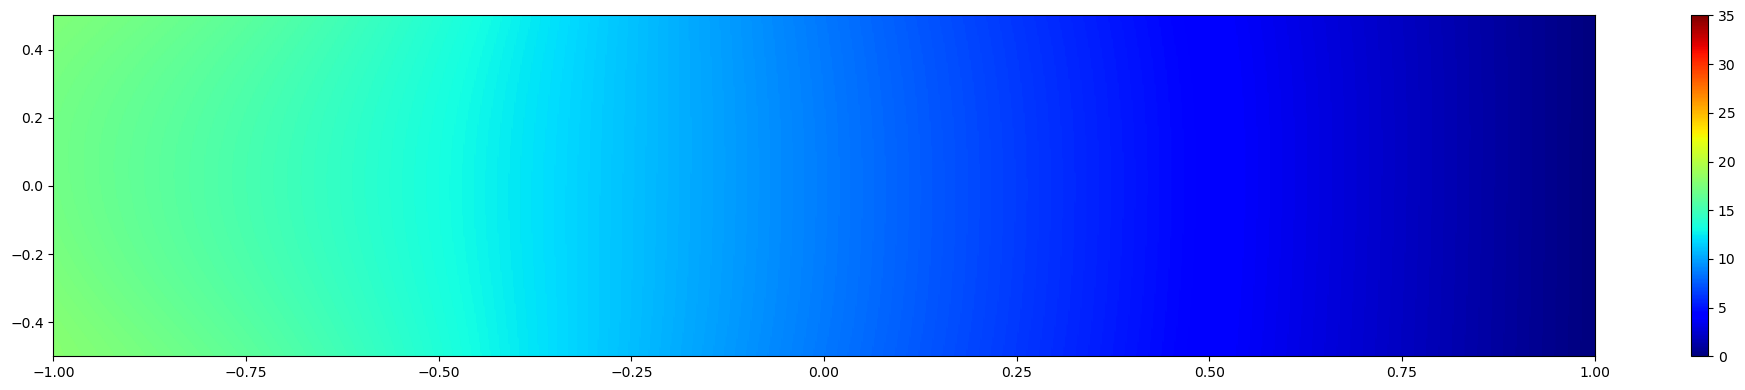

In [18]:
samples = geom.uniform_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize=(20, 4))
    plt.scatter(samples[:, 0], samples[:, 1], c = result[:, idx], cmap='jet', s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((-L/2, L/2))
    plt.ylim((-D/2, D/2))
    plt.tight_layout()
    plt.show()

In [19]:
dde.optimizers.config.set_LBFGS_options(maxiter=1000)
model.compile("L-BFGS")

Compiling model...
'compile' took 0.010389 s



Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [3.12e-03, 5.39e-04, 1.86e-03, 1.83e-02, 5.95e-03, 1.52e-02, 6.90e-03, 3.14e-04, 1.69e-05]    [2.92e-03, 4.71e-04, 8.50e-04, 1.83e-02, 5.95e-03, 1.52e-02, 6.90e-03, 3.14e-04, 1.69e-05]    []  
11000     [1.04e-03, 9.09e-04, 1.17e-03, 1.18e-02, 1.39e-03, 6.64e-03, 2.78e-03, 2.61e-05, 8.82e-07]    [7.02e-04, 8.82e-04, 9.92e-04, 1.18e-02, 1.39e-03, 6.64e-03, 2.78e-03, 2.61e-05, 8.82e-07]    []  

Best model at step 11000:
  train loss: 2.58e-02
  test loss: 2.52e-02
  test metric: []

'train' took 347.393644 s



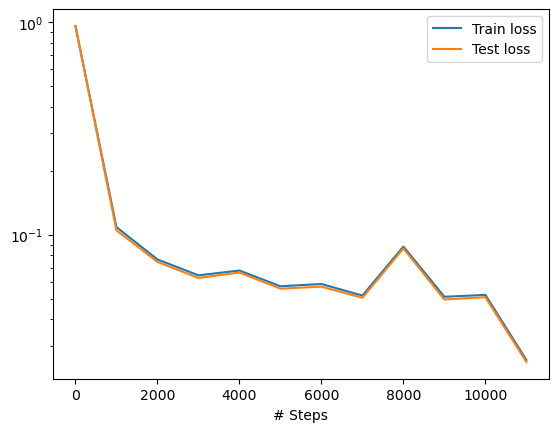

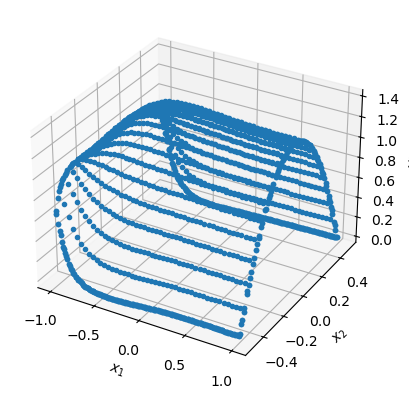

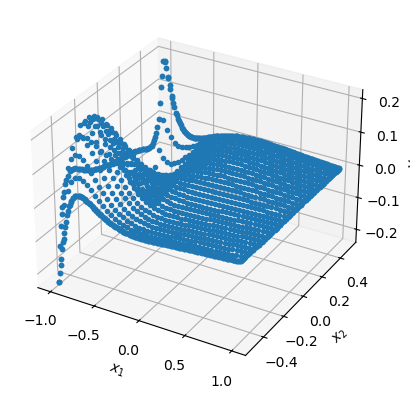

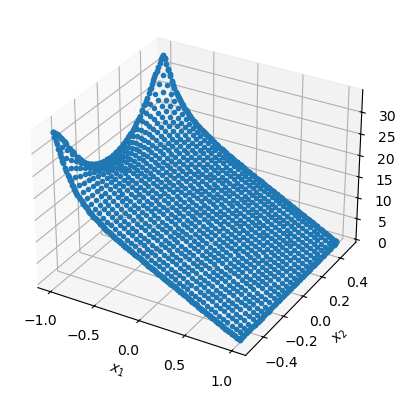

In [20]:
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

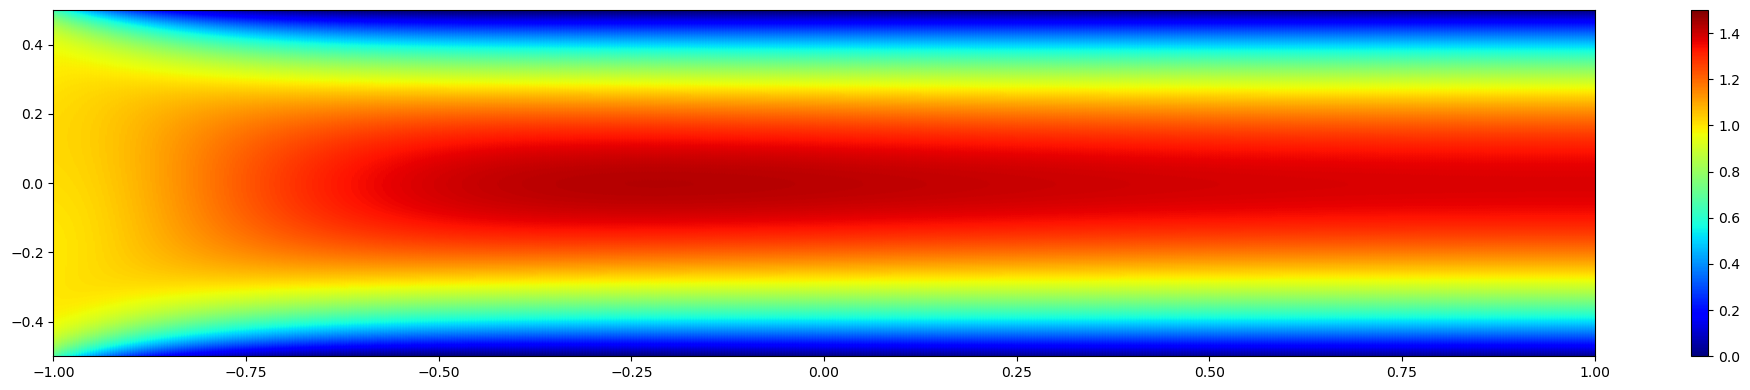

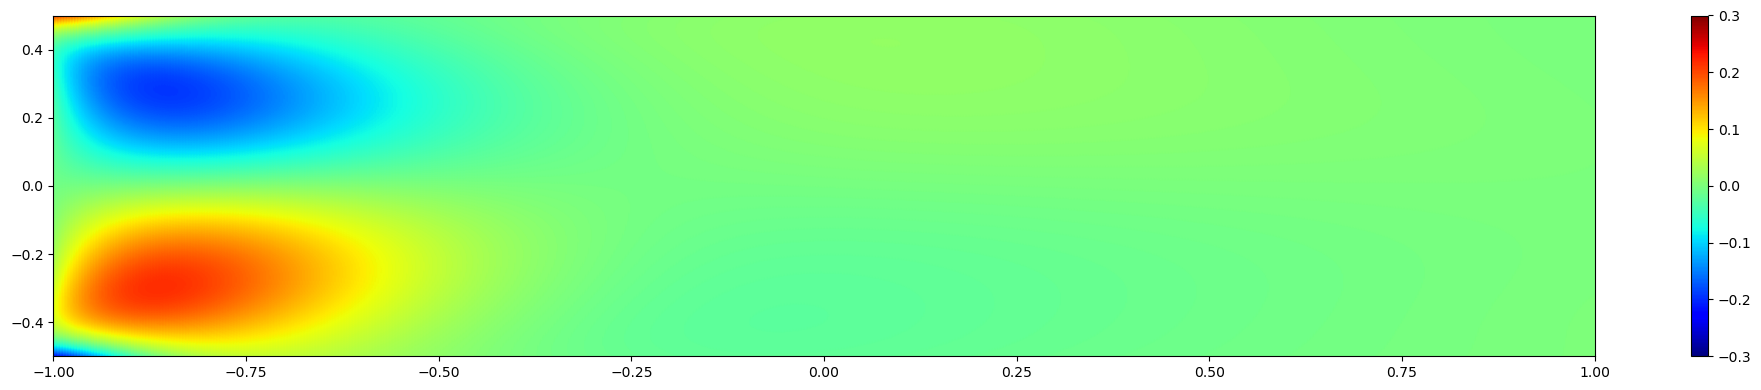

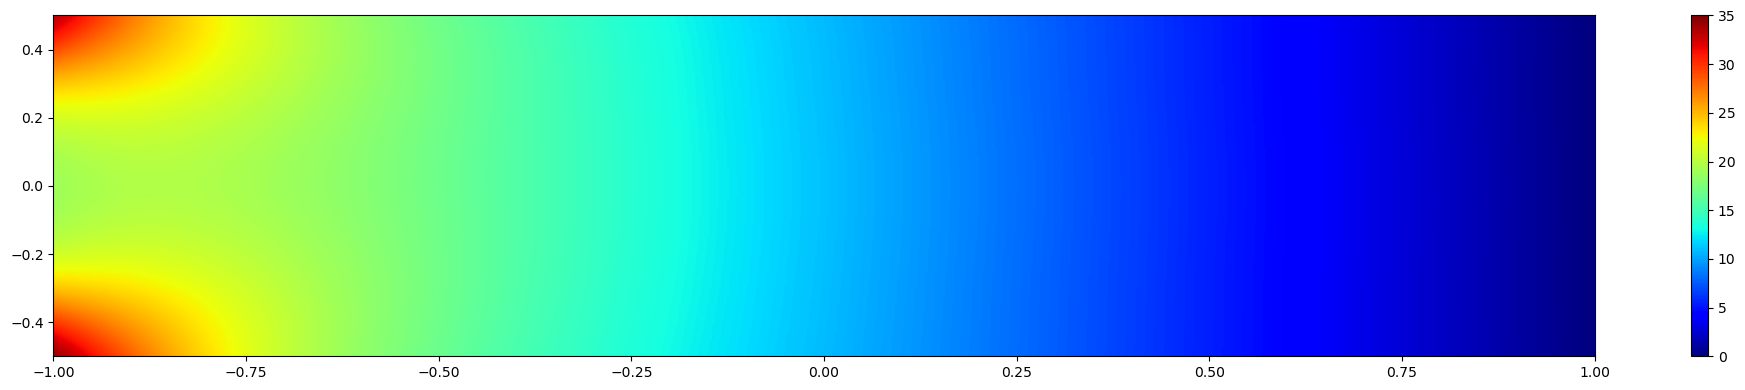

In [21]:
samples = geom.uniform_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize=(20, 4))
    plt.scatter(samples[:, 0], samples[:, 1], c = result[:, idx], cmap='jet', s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((-L/2, L/2))
    plt.ylim((-D/2, D/2))
    plt.tight_layout()
    plt.show()

In [27]:
x = np.ones([1000, 1])
y = np.linspace(-D/2, D/2, 1000).reshape(-1, 1)
outlet = np.hstack([x, y])
outlet.shape

(1000, 2)

In [29]:
u_true_outlet = 1.5 * u_in * (1 - ((y)/(D/2))**2)
u_true_outlet.shape

(1000, 1)

In [30]:
pinn_solution = model.predict(outlet)
pinn_solution.shape

(1000, 3)

In [31]:
u_pred_outlet = pinn_solution[:, 0]
u_pred_outlet.shape

(1000,)

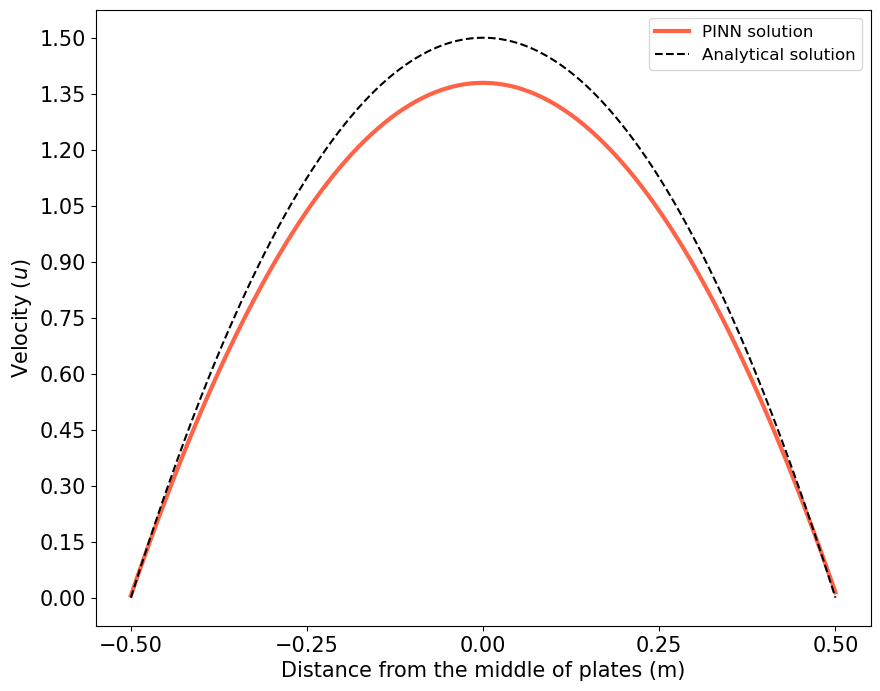

In [36]:
plt.figure(figsize=(10, 8))
plt.plot(y, u_pred_outlet, c='tomato', linewidth=3, label='PINN solution')
plt.plot(y, u_true_outlet, c='k', linestyle='--', label='Analytical solution')
plt.xticks(np.linspace(-D/2, D/2, 5), fontsize=15)
plt.yticks(np.linspace(0, 1.5, 11), fontsize=15)
plt.legend(fontsize=12)
plt.xlabel('Distance from the middle of plates (m)', fontsize=15)
plt.ylabel('Velocity ($u$)', fontsize=15)
plt.show()